## 对实验其他因素的探究

In [2]:
import cv2
import numpy as np
from skimage.transform import resize
from sklearn.cluster import KMeans
from hmmlearn import hmm
import os 
import matplotlib.pyplot as plt

#### 1、分别在不同特征下(Dense Trajectories, SIFT, HOG)对模型结果进行评估


提取视频各帧图像的特征(Dense Trajectories, SIFT, HOG)
帧/s

In [3]:
def extract_features_dt_f(video_file):
    cap = cv2.VideoCapture(video_file)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    dense_sampling_interval = frame_rate
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    total_frames = min(frame_count, frame_rate * 100) 
    dense_trajectories = []
    prev_gray = None
    frame_number = 0
    hsvs=[]
    angs=[]
    hsv = np.zeros((96, 96, 3))
    while frame_number < total_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (96, 96))
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if prev_gray is not None:
            flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            hsv[..., 0] = ang * 180 / np.pi / 2
            hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
            dense_trajectories.append(hsv.flatten())
            hsvs.append(mag)
            angs.append(hsv[..., 0] )
        
        prev_gray = gray
        frame_number += dense_sampling_interval
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    cap.release()
    return np.array(dense_trajectories),np.array(dense_trajectories).shape[0],hsvs,angs

In [7]:
def extract_features_hog(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    total_frames = min(frame_count, frame_rate * 100)  
    samples_per_second = frame_count / total_frames
    hog = cv2.HOGDescriptor((72,96),(12,12),(12,12),(6,6),9)
    features = []
    print(total_frames)
    for i in range(0,total_frames, frame_rate):
        frame_index = int(i * samples_per_second)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        ret, frame = cap.read()
        if not ret:
            break
        
        resized_frame = cv2.resize(frame, (120, 160))
        resized_frame = np.array(resized_frame * 255, dtype=np.uint8)  
        gray_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
        
        hog_features = hog.compute(gray_frame,(36,36),padding=(12,12))
        features.append(hog_features.flatten())
    cap.release()
    return features, len(features)

In [12]:
def extract_features_sift(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    total_frames = min(frame_count, frame_rate * 100)  
    samples_per_second = frame_count / total_frames
    features = []
    sift = cv2.SIFT_create()
    for i in range(0,total_frames,int(frame_rate)):
        frame_index = int(i * samples_per_second)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        ret, frame = cap.read()
        if not ret:
             break
        
        resized_frame = cv2.resize(frame, (120, 160))
        resized_frame = np.array(resized_frame * 255, dtype=np.uint8)  
        gray_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
       
        keypoints, descriptors = sift.detectAndCompute(gray_frame, None)
       
        if descriptors is not None:
             features.append(descriptors.flatten())
        else:
            features.append(np.array([0,0]).astype(np.float32)) 
    cap.release()
    return np.array(features), len(features)

可视化提取各种特征的效果

(120, 160, 3)


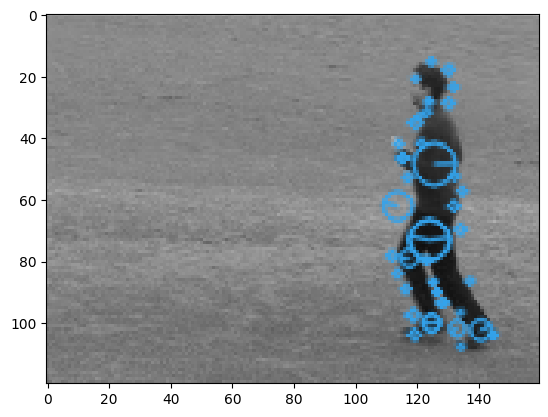

: 

In [1]:
#--------SIFT特征-----------------
from PIL import Image
from pylab import *
import cv2
# 添加中文字体支持
from matplotlib.font_manager import FontProperties

def extract_frame_from_video(video_path, frame_number):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()

    if ret:
        return frame
    else:
        return None

video_path = r"data\jogging\person01_jogging_d1_uncomp.avi" 
imname = extract_frame_from_video(video_path, 15)
img = imname
print(img.shape)
cv2.imshow("original",img)
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
#使用SIFT
sift = cv2.xfeatures2d.SIFT_create()
keypoints, descriptor = sift.detectAndCompute(gray,None)
 
cv2.drawKeypoints(image = img,
                  outImage = img,
                  keypoints = keypoints,
                  flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
                  color = (51,163,236))

plt.imshow(img)

In [ ]:
video_path = r"data\jogging\person01_jogging_d1_uncomp.avi"  # Replace this with the path to your video
features,_,mag ,angs= extract_features_dt_f(video_path)
print(f'Shape of features: {features.shape}')
print(len(features))
print(features[15][int(2*len(features[0])/3):].shape)
# plt.imshow(features[11][int(2*len(features[0])/3):].reshape(96,96))
plt.imshow(mag[10].reshape(96,96))

提取各个动作的视频的特征，制作数据集

In [5]:
#--------------------------dt--------------------
data = []
labels = []
frames=[]
data_dir = "data"
actions = ["walking", "boxing", "handclapping", "jogging", "running", "handwaving"]
for action_label, action in enumerate(actions):
    action_dir = os.path.join(data_dir, action)
    for filename in os.listdir(action_dir):
        video_path = os.path.join(action_dir, filename)
        # Extract features from the video
        video_features,frame = extract_features_dt_f(video_path)
        # Append processed data and corresponding label
        data.append(video_features)
        labels.append(action_label)
        frames.append(frame)

In [ ]:
#-------------------sift---------------
data = []
labels = []
frames=[]
data_dir = "data"
actions = ["walking", "boxing", "handclapping", "jogging", "running", "handwaving"]
for action_label, action in enumerate(actions):
    action_dir = os.path.join(data_dir, action)
    for filename in os.listdir(action_dir):
        video_path = os.path.join(action_dir, filename)
        # Extract features from the video
        video_features,frame = extract_features_sift(video_path)
        # Append processed data and corresponding label
        data.append(video_features)
        labels.append(action_label)
        frames.append(frame)

检查数据长度，存储数据集至文件

In [6]:
import pickle
print(len(data))
with open('data/data_dt_f.pkl', 'wb') as f:
    pickle.dump(data, f)
# 将数据存储为.pkl文件
with open('data/labels.pkl', 'wb') as f:
    pickle.dump(labels, f)
with open('data/frames.pkl', 'wb') as f:
    pickle.dump(frames, f)

599


In [1]:

import pickle
#---------------------dt-----------------------
with open('data/data_dt_f.pkl', 'rb') as f:
     data = pickle.load(f)
# 从.pkl文件加载数据
with open('data/labels_dt_f.pkl', 'rb') as f:
    labels = pickle.load(f)
with open('data/frames.pkl', 'rb') as f:
     frames = pickle.load(f)

In [2]:
# print(data_pad[103].shape)
print(data[399].shape)
#num_frames=data[399].shape[0]
n_features=data[399].shape[1]

(13, 19200)


In [3]:
assert len(data)==599
print(data[103].shape)
data[590].shape

(12, 19200)


(21, 19200)

In [78]:
len(data[209])

17

将各个动作视频分开，因为后续要单独聚类

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

actions = ["walking", "boxing", "handclapping", "jogging", "running", "handwaving"]
data_walk=data[0:100]
data_box=data[100:200]
data_handclap=data[200:299]
data_jog=data[299:399]
data_run=data[399:499]
data_wave=data[499:599]
frames_walk=frames[0:100]
frames_box=frames[100:200]
frames_handclap=frames[200:299]
frames_jog=frames[299:399]
frames_run=frames[399:499]
frames_wave=frames[499:599]

对图像的DT特征进行PCA降维

In [7]:
labels_ = []  # 用来存储分割后的序列列表
for i,label in enumerate(labels):
    for j in range(frames[i]):
        labels_.append(label)
labels_ = np.array(labels_)

In [8]:
assert len(labels_)==11254

In [9]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# 假设 data 是您的数据集，形状为 (598, 50, 15552)
# 重新组织数据，将每个视频的帧、x坐标和y坐标合并成特征向量

data_walk=np.vstack(data_walk)
data_box=np.vstack(data_box)
data_handclap=np.vstack(data_handclap)
data_jog=np.vstack(data_jog)
data_run=np.vstack(data_run)
data_wave=np.vstack(data_wave)
data=np.vstack(data)



n_pca=60     #主成分个数
pca=PCA(n_components=n_pca)
pca.fit(data)
data_pca_walk = pca.transform(data_walk)
data_pca_box = pca.transform(data_box)
data_pca_handclap= pca.transform(data_handclap)
data_pca_jog = pca.transform(data_jog)
data_pca_run = pca.transform(data_run)
data_pca_wave = pca.transform(data_wave)
data_pca=pca.transform(data)
n_lda=5
# 对每个数据点进行降维
lda =  LinearDiscriminantAnalysis(n_components=n_lda)
lda.fit(np.concatenate([data_pca_walk,data_pca_box,data_pca_handclap,data_pca_jog,data_pca_run,data_pca_wave]),labels_)
data_lda = lda.transform(data_pca)

In [ ]:
with open('pca/data_pca_walk.pkl', 'wb') as f:
    pickle.dump(data_pca_walk, f)
# 将数据存储为.pkl文件
with open('pca/data_pca_box.pkl', 'wb') as f:
    pickle.dump(data_pca_box, f)
with open('pca/data_pca_handclap.pkl', 'wb') as f:
    pickle.dump(data_pca_handclap, f)
with open('pca/data_pca_jog.pkl', 'wb') as f:
    pickle.dump(data_pca_jog, f)
with open('pca/data_pca_run.pkl', 'wb') as f:
    pickle.dump(data_pca_run, f)
with open('pca/data_pca_wave.pkl', 'wb') as f:
    pickle.dump(data_pca_wave, f)

主成分数目的确定

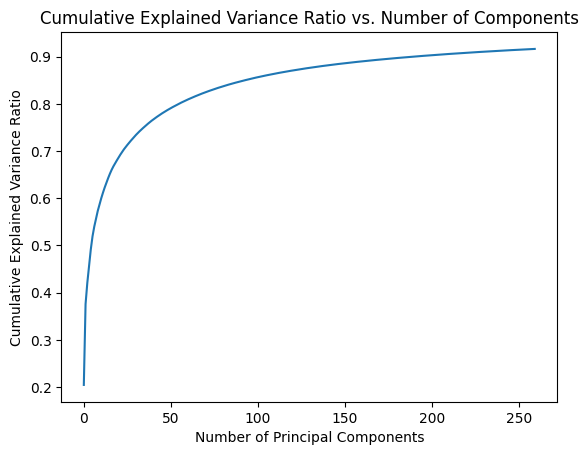

In [83]:
import matplotlib.pyplot as plt
# 绘制累积可解释方差比例的曲线
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.show()

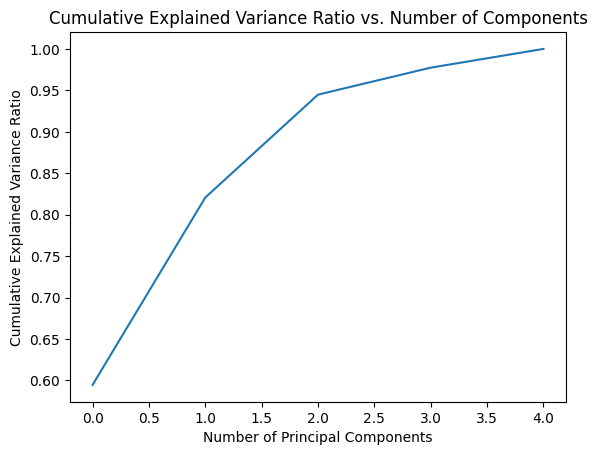

In [84]:
import matplotlib.pyplot as plt
# 绘制累积可解释方差比例的曲线
plt.plot(np.cumsum(lda.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.show()

In [85]:
assert data_walk.shape[0]==sum(frames_walk)
assert data_box.shape[0]==sum(frames_box)
assert data_handclap.shape[0]==sum(frames_handclap)
assert data_jog.shape[0]==sum(frames_jog)
assert data_run.shape[0]==sum(frames_run)
assert data_wave.shape[0]==sum(frames_wave)

#### 2、分别在不同聚类算法下对模型结果进行评估


In [ ]:
# 对各种视频单独进行KMeans聚类
num_clusters = 6  

kmeans_walk = KMeans(n_clusters=num_clusters, random_state=0,n_init=300)
clusters_walk = kmeans_walk.fit_predict(data_pca_walk) 

kmeans_box = KMeans(n_clusters=num_clusters, random_state=0,n_init=300)
clusters_box = kmeans_box.fit_predict(data_pca_box)

kmeans_handclap = KMeans(n_clusters=num_clusters, random_state=0,n_init=300)
clusters_handclap = kmeans_handclap.fit_predict(data_pca_handclap) 

kmeans_jog = KMeans(n_clusters=num_clusters, random_state=0,n_init=300)
clusters_jog = kmeans_jog.fit_predict(data_pca_jog) 

kmeans_run = KMeans(n_clusters=num_clusters, random_state=0,n_init=300)
clusters_run = kmeans_run.fit_predict(data_pca_run) 

kmeans_wave = KMeans(n_clusters=num_clusters, random_state=0,n_init=300)
clusters_wave = kmeans_wave.fit_predict(data_pca_wave) 

##### 对各种视频单独进行层次聚类


In [ ]:
from sklearn.cluster import AgglomerativeClustering
num_clusters = 6  

agg_walk = AgglomerativeClustering(n_clusters=num_clusters, random_state=0,n_init=300)
agg_clusters_walk = agg_walk.fit_predict(data_pca_walk) 

agg_box = AgglomerativeClustering(n_clusters=num_clusters, random_state=0,n_init=300)
agg_clusters_box = agg_box.fit_predict(data_pca_box)

agg_handclap = AgglomerativeClustering(n_clusters=num_clusters, random_state=0,n_init=300)
agg_clusters_handclap = agg_handclap.fit_predict(data_pca_handclap)

agg_jog = AgglomerativeClustering(n_clusters=num_clusters, random_state=0,n_init=300)
agg_clusters_jog = agg_jog.fit_predict(data_pca_jog)

agg_run = AgglomerativeClustering(n_clusters=num_clusters, random_state=0,n_init=300)
agg_clusters_run = agg_run.fit_predict(data_pca_run)

agg_wave = AgglomerativeClustering(n_clusters=num_clusters, random_state=0,n_init=300)
agg_clusters_wave = agg_wave.fit_predict(data_pca_wave)

In [ ]:
import numpy as np
from sklearn_extra.cluster import KMedoids
import tslearn.metrics as metrics
# 自定义数据处理
from tslearn.clustering import silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.generators import random_walks
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def test_kmedoids_kmeans(X, km, y_pred):
    dists = euclidean_distances(X)
    #y_pred = km.fit_predict(dists)
    np.fill_diagonal(dists,0)
    score = silhouette_score(dists,y_pred,metric="precomputed")
    print("silhouette_score: " + str(score))
    #plt.figure(figsize=(10, 8))
    for yi in range(6):
        plt.subplot(3, 2, yi + 1)
        for xx in X[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.3)
        plt.plot(km.cluster_centers_[yi], "r-")  # 使用km.cluster_centers_获取KMeans的中心点
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                transform=plt.gca().transAxes)
        if yi == 1:
            plt.title("KMeans")
            
    plt.tight_layout()
    plt.show()

def test_kmedoids_agg(X, km, y_pred):
    dists = euclidean_distances(X)
    #y_pred = km.fit_predict(dists)
    np.fill_diagonal(dists,0)
    score = silhouette_score(dists,y_pred,metric="precomputed")
    print("silhouette_score: " + str(score))
    #plt.figure(figsize=(10, 8))
    for yi in range(6):
        plt.subplot(3, 2, yi + 1)
        for xx in X[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.3)
        plt.plot(km.cluster_centers_[yi], "r-")  # 使用km.cluster_centers_获取KMeans的中心点
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                transform=plt.gca().transAxes)
        if yi == 1:
            plt.title("Agg")
            
    plt.tight_layout()
    plt.show()


test_kmedoids_kmeans(data_pca_walk,  kmeans_walk, clusters_walk)

test_kmedoids_agg(data_pca_walk, agg_walk, agg_clusters_walk)

In [114]:

clusters_walk_ = []  # 用来存储分割后的序列列表
start_idx = 0
for frame in frames_walk:
    # 根据frames数组中的值，从data中分割出一个序列
    sequence = clusters_walk[start_idx:start_idx + frame]
    # 将该序列添加到sequences列表中
    clusters_walk_.append(sequence)
    # 更新起始索引
    start_idx += frame
#data_walk = np.array(clusters_walk_)

clusters_box_ = []  # 用来存储分割后的序列列表
start_idx = 0
for frame in frames_box:
    # 根据frames数组中的值，从data中分割出一个序列
    sequence = clusters_box[start_idx:start_idx + frame]
    # 将该序列添加到sequences列表中
    clusters_box_.append(sequence)
    # 更新起始索引
    start_idx += frame
#data_box = np.array(clusters_box_)

clusters_handclap_ = []  # 用来存储分割后的序列列表
start_idx = 0
for frame in frames_handclap:
    # 根据frames数组中的值，从data中分割出一个序列
    sequence = clusters_handclap[start_idx:start_idx + frame]
    # 将该序列添加到sequences列表中
    clusters_handclap_.append(sequence)
    # 更新起始索引
    start_idx += frame
#data_handclap = np.array(clusters_handclap_)

clusters_jog_ = []  # 用来存储分割后的序列列表
start_idx = 0
for frame in frames_jog:
    # 根据frames数组中的值，从data中分割出一个序列
    sequence = clusters_jog[start_idx:start_idx + frame]
    # 将该序列添加到sequences列表中
    clusters_jog_.append(sequence)
    # 更新起始索引
    start_idx += frame
#data_jog = np.array(clusters_jog_)

clusters_run_ = []  # 用来存储分割后的序列列表
start_idx = 0
for frame in frames_run:
    # 根据frames数组中的值，从data中分割出一个序列
    sequence = clusters_run[start_idx:start_idx + frame]
    # 将该序列添加到sequences列表中
    clusters_run_.append(sequence)
    # 更新起始索引
    start_idx += frame
#data_run= np.array(clusters_run_)

clusters_wave_ = []  # 用来存储分割后的序列列表
start_idx = 0
for frame in frames_wave:
    # 根据frames数组中的值，从data中分割出一个序列
    sequence = clusters_wave[start_idx:start_idx + frame]
    # 将该序列添加到sequences列表中
    clusters_wave_.append(sequence)
    # 更新起始索引
    start_idx += frame
#data_wave = np.array(clusters_wave_)

clusters_ = []  # 用来存储分割后的序列列表
start_idx = 0
for frame in frames:
    # 根据frames数组中的值，从data中分割出一个序列
    sequence = clusters[start_idx:start_idx + frame]
    # 将该序列添加到sequences列表中
    clusters_.append(sequence)
    # 更新起始索引
    start_idx += frame
#data_all = np.array(clusters_)

# 输出聚类结果
for video_index, cluster_label in enumerate(clusters_walk_):
    print(f"walk视频{video_index+1}的聚类结果：{cluster_label}")
    
# 输出聚类结果
for video_index, cluster_label in enumerate(clusters_box_):
    print(f"box视频{video_index+1}的聚类结果：{cluster_label}")
    
# 输出聚类结果
for video_index, cluster_label in enumerate(clusters_handclap_):
    print(f"handclap视频{video_index+1}的聚类结果：{cluster_label}")
    
# 输出聚类结果
for video_index, cluster_label in enumerate(clusters_jog_):
    print(f"jog视频{video_index+1}的聚类结果：{cluster_label}")
    
# 输出聚类结果
for video_index, cluster_label in enumerate(clusters_run_):
    print(f"run视频{video_index+1}的聚类结果：{cluster_label}")

# 输出聚类结果
for video_index, cluster_label in enumerate(clusters_wave_):
    print(f"wave视频{video_index+1}的聚类结果：{cluster_label}")

walk视频1的聚类结果：[0 2 5 1 4 4 3 5 0 1 4 4 1 2 2 5 1 4 4 5 5 0]
walk视频2的聚类结果：[0 0 3 5 5 1 2 5 5 0 0 2 1 1 1 0 0 3 5 5 4 1 5 3 3 2]
walk视频3的聚类结果：[2 0 1 3 4 1 4 3 0 2 1 1 4 4 0 0 5 1 4 1 3 5 2 1 4 4 4 4 4 2 2 5 1 1 4 5 0]
walk视频4的聚类结果：[2 0 5 5 3 3 3 3 0 2 2 0 0 3 5 5 2 3 3 5 2 2]
walk视频5的聚类结果：[0 0 5 1 1 4 3 5 2 0 2 3 4 1 1 3 0]
walk视频6的聚类结果：[1 5 5 5 5 2 2 0 0 4 1 2 0 2 2 3 3 3 3 4 2 1 1 1 4 4 5 5 5 5 5 2 2 2 1 0 0
 5 5 5 5 3]
walk视频7的聚类结果：[2 0 5 5 1 1 1 3 5 2 4 2 2 5 3 1 1 1 3 5 0]
walk视频8的聚类结果：[2 0 3 3 3 3 0 2 0 2 0 0 3 5 3 3 0 2]
walk视频9的聚类结果：[0 2 3 5 1 4 4 4 4 5 5 0 2 1 1 4 4 2 0 3 5 1 3 3 2]
walk视频10的聚类结果：[4 0 2 0 2 0 3 3 3 1 3 3 5 0 2 0 2 0 1 5 2 0 2 0 0 5 5 3 1 4 4 5 3 2 0 2 0
 2]
walk视频11的聚类结果：[1 0 2 3 3 4 0 1 5 3 3 0 0 1 4 4 1 1 1 4 1 1 4 0 2 2 3 1 1 4 5 5 2 0 4 0 2
 5 3 4 1 5 5 0]
walk视频12的聚类结果：[3 3 2 2 2 2 0 5 5 5 3 2 0 0 2 0 3]
walk视频13的聚类结果：[2 0 3 5 3 5 2 2 0 1 2 0 2 5 5 5 3 2]
walk视频14的聚类结果：[5 3 5 0 3 3 1 1 5 3 3 3 5 5 5 5 2 4 5 5 5 5 5 5 5 4 4 5 5 5 3 3 5]
walk视频15的聚类结果：[2 0 5 1

In [117]:
#np.array(clusters_walk_)
clusters_walk_

[array([0, 2, 5, 1, 4, 4, 3, 5, 0, 1, 4, 4, 1, 2, 2, 5, 1, 4, 4, 5, 5, 0]),
 array([0, 0, 3, 5, 5, 1, 2, 5, 5, 0, 0, 2, 1, 1, 1, 0, 0, 3, 5, 5, 4, 1,
        5, 3, 3, 2]),
 array([2, 0, 1, 3, 4, 1, 4, 3, 0, 2, 1, 1, 4, 4, 0, 0, 5, 1, 4, 1, 3, 5,
        2, 1, 4, 4, 4, 4, 4, 2, 2, 5, 1, 1, 4, 5, 0]),
 array([2, 0, 5, 5, 3, 3, 3, 3, 0, 2, 2, 0, 0, 3, 5, 5, 2, 3, 3, 5, 2, 2]),
 array([0, 0, 5, 1, 1, 4, 3, 5, 2, 0, 2, 3, 4, 1, 1, 3, 0]),
 array([1, 5, 5, 5, 5, 2, 2, 0, 0, 4, 1, 2, 0, 2, 2, 3, 3, 3, 3, 4, 2, 1,
        1, 1, 4, 4, 5, 5, 5, 5, 5, 2, 2, 2, 1, 0, 0, 5, 5, 5, 5, 3]),
 array([2, 0, 5, 5, 1, 1, 1, 3, 5, 2, 4, 2, 2, 5, 3, 1, 1, 1, 3, 5, 0]),
 array([2, 0, 3, 3, 3, 3, 0, 2, 0, 2, 0, 0, 3, 5, 3, 3, 0, 2]),
 array([0, 2, 3, 5, 1, 4, 4, 4, 4, 5, 5, 0, 2, 1, 1, 4, 4, 2, 0, 3, 5, 1,
        3, 3, 2]),
 array([4, 0, 2, 0, 2, 0, 3, 3, 3, 1, 3, 3, 5, 0, 2, 0, 2, 0, 1, 5, 2, 0,
        2, 0, 0, 5, 5, 3, 1, 4, 4, 5, 3, 2, 0, 2, 0, 2]),
 array([1, 0, 2, 3, 3, 4, 0, 1, 5, 3, 3, 0, 0, 1, 4, 4, 

加载标签数据

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# 划分训练集和测试集
split=0.5
X_train_walk=clusters_walk_[::2]
X_test_walk=clusters_walk_[1::2]

X_train_box=clusters_box_[::2]
X_test_box=clusters_box_[1::2]

X_train_handclap=clusters_handclap_[::2]
X_test_handclap=clusters_handclap_[1::2]

X_train_jog=clusters_jog_[::2]
X_test_jog=clusters_jog_[1::2]

X_train_run=clusters_run_[::2]
X_test_run=clusters_run_[1::2]

X_train_wave=clusters_wave_[::2]
X_test_wave=clusters_wave_[1::2]

#制作训练序列
data_walk=np.concatenate([i for i in X_train_walk]).reshape(-1,1)
data_box=np.concatenate([i for i in X_train_box]).reshape(-1,1)
data_handclap=np.concatenate([i for i in X_train_handclap]).reshape(-1,1)
data_jog=np.concatenate([i for i in X_train_jog]).reshape(-1,1)
data_run=np.concatenate([i for i in X_train_run]).reshape(-1,1)
data_wave=np.concatenate([i for i in X_train_wave]).reshape(-1,1)
#序列长度

x_len_walk=frames_walk[::2]
x_len_box=frames_box[::2]
x_len_handclap=frames_handclap[::2]
x_len_jog=frames_jog[::2]
x_len_run=frames_run[::2]
x_len_wave=frames_wave[::2]

x_len_walk_=frames_walk[1::2]
x_len_box_=frames_box[1::2]
x_len_handclap_=frames_handclap[1::2]
x_len_jog_=frames_jog[1::2]
x_len_run_=frames_run[1::2]
x_len_wave_=frames_wave[1::2]

labels_walk=labels[0:100]
labels_box=labels[100:200]
labels_handclap=labels[200:299]
labels_jog=labels[299:399]
labels_run=labels[399:499]
labels_wave=labels[499:599]

In [121]:
print(len(data_handclap))
print(sum(x_len_handclap))
assert len(data_walk)==sum(x_len_walk)
assert len(data_box)==sum(x_len_box)
assert len(data_handclap)==sum(x_len_handclap)
assert len(data_jog)==sum(x_len_jog)
assert len(data_run)==sum(x_len_run)
assert len(data_wave)==sum(x_len_wave)

826
826


训练隐马尔可夫分类模型

hmm模型的参数

		n_components：一个整数，指定了状态的数量。
		covariance_type：一个字符串，指定了使用方差矩阵的类型。可以为：
				'spherical'：对每个状态，该状态的所有特征的方差都是同一个值。
				'diag'：每个状态的方差矩阵为对角矩阵。
				'full'：每个状态的方差矩阵为普通的矩阵。
				'tied'：所有状态都是用同一个普通的方差矩阵。
		min_covar：一个浮点数。给出了方差矩阵对角线上元素的最小值，用于防止过拟合。
		startprob_prior：一个数组，形状为(n_components, )。初始状态的先验概率分布。
		transmat_prior：一个数字，形状为(n_components, n_components )。先验的状态转移矩阵。
		algorithm：一个字符串。指定了Decoder算法。可以为 'viterbi'（维特比算法）或者'map' 。
		random_state：指定随机数种子。
		tol：指定迭代收敛阈值。
		verbose：指定打印日志。
		params：一个字符串。控制在训练过程中，哪些参数能够得到更新（你也可以指定它们的组合形式）：
				's'：初始概率。
				't'：转移概率。
				'm'：均值。
				'c'：偏差。
		init_params：一个字符串。控制在训练之前，先初始化哪些参数（你也可以指定它们的组合形式）：
				's'：初始概率。
				't'：转移概率。
				'm'：均值。
				'c'：偏差。


In [ ]:
from hmmlearn import hmm

n_hmm=6#隐藏节点个数
#assert n_hmm<10
n_iter=300              #代最大个数   调大点 >200
algorithm='map'     #解码算法   最大后验概率解码       'viterbi'维特比解码算法
tol=0.001           #相邻两次迭代之间对数似然变化 迭代终止阈值
init_params='sc' #stemc  stec-56% sec-57% sc-58% c-51%
n_features=220 
assert n_features>=num_clusters
min_covar=0.1
#迭代算法：EM算法
#-----------高斯分布---------
# model_walk = hmm.GaussianHMM(n_components=n_hmm,covariance_type="full", n_iter=n_iter,algorithm=algorithm,verbose=True,tol=tol,init_params=init_params,min_covar=min_covar)
# model_box = hmm.GaussianHMM(n_components=n_hmm, covariance_type="full", n_iter=n_iter,algorithm=algorithm,verbose=True,tol=tol,init_params=init_params)
# model_handclap= hmm.GaussianHMM(n_components=n_hmm, covariance_type="full",n_iter=n_iter,algorithm=algorithm,verbose=True,tol=tol,init_params=init_params)
# model_jog = hmm.GaussianHMM(n_components=n_hmm, covariance_type="full", n_iter=n_iter,algorithm=algorithm,verbose=True,tol=tol,init_params=init_params)
# model_run = hmm.GaussianHMM(n_components=n_hmm, covariance_type="full", n_iter=n_iter,algorithm=algorithm,verbose=True,tol=tol,init_params=init_params)
# model_handwave = hmm.GaussianHMM(n_components=n_hmm, covariance_type="full", n_iter=n_iter,algorithm=algorithm,verbose=True,tol=tol,init_params=init_params)
#--------混合高斯分布------------
# model_walk = hmm.GMMHMM(n_components=n_hmm,covariance_type="full", n_iter=n_iter,algorithm=algorithm,verbose=True,tol=tol,init_params=init_params,min_covar=min_covar)
# model_box = hmm.GMMHMM(n_components=n_hmm, covariance_type="full", n_iter=n_iter,algorithm=algorithm,verbose=True,tol=tol,init_params=init_params,min_covar=min_covar)
# model_handclap= hmm.GMMHMM(n_components=n_hmm, covariance_type="full",n_iter=n_iter,algorithm=algorithm,verbose=True,tol=tol,init_params=init_params,min_covar=min_covar)
# model_jog = hmm.GMMHMM(n_components=n_hmm, covariance_type="full", n_iter=n_iter,algorithm=algorithm,verbose=True,tol=tol,init_params=init_params,min_covar=min_covar)
# model_run = hmm.GMMHMM(n_components=n_hmm, covariance_type="full", n_iter=n_iter,algorithm=algorithm,verbose=True,tol=tol,init_params=init_params,min_covar=min_covar)
# model_handwave = hmm.GMMHMM(n_components=n_hmm, covariance_type="full", n_iter=n_iter,algorithm=algorithm,verbose=True,tol=tol,init_params=init_params,min_covar=min_covar)
#--------多项式--------------------

model_walk = hmm.CategoricalHMM(n_components=n_hmm, n_iter=n_iter,algorithm=algorithm,verbose=True,tol=tol,init_params=init_params,n_features=n_features)
model_box = hmm.CategoricalHMM(n_components=n_hmm,  n_iter=n_iter,algorithm=algorithm,verbose=True,tol=tol,init_params=init_params,n_features=n_features)
model_handclap= hmm.CategoricalHMM(n_components=n_hmm, n_iter=n_iter,algorithm=algorithm,verbose=True,tol=tol,init_params=init_params,n_features=n_features)
model_jog = hmm.CategoricalHMM(n_components=n_hmm,  n_iter=n_iter,algorithm=algorithm,verbose=True,tol=tol,init_params=init_params,n_features=n_features)
model_run = hmm.CategoricalHMM(n_components=n_hmm, n_iter=n_iter,algorithm=algorithm,verbose=True,tol=tol,init_params=init_params,n_features=n_features)
model_handwave = hmm.CategoricalHMM(n_components=n_hmm,  n_iter=n_iter,algorithm=algorithm,verbose=True,tol=tol,init_params=init_params,n_features=n_features)

model_walk.fit(data_walk,x_len_walk)
model_box.fit(data_box,x_len_box)
model_handclap.fit(data_handclap,x_len_handclap)
model_jog.fit(data_jog,x_len_jog)
model_run.fit(data_run,x_len_run)
model_handwave.fit(data_wave,x_len_wave)

输出转移概率矩阵

制作测试集和训练集

In [ ]:
train_labels_walk=labels_walk[::2]
train_labels_box=labels_box[::2]
train_labels_handclap=labels_handclap[::2]
train_labels_jog=labels_jog[::2]
train_labels_run=labels_run[::2]
train_labels_wave=labels_wave[::2]
X_train=np.concatenate([X_train_walk,X_train_box,X_train_handclap,X_train_jog,X_train_run,X_train_wave])
y_train=np.concatenate([train_labels_walk,train_labels_box,train_labels_handclap,train_labels_jog,train_labels_run,train_labels_wave])
test_labels_walk=labels_walk[1::2]
test_labels_box=labels_box[1::2]
test_labels_handclap=labels_handclap[1::2]
test_labels_jog=labels_jog[1::2]
test_labels_run=labels_run[1::2]
test_labels_wave=labels_wave[1::2]
X_test=np.concatenate([X_test_walk,X_test_box,X_test_handclap,X_test_jog,X_test_run,X_test_wave])
y_test=np.concatenate([test_labels_walk,test_labels_box,test_labels_handclap,test_labels_jog,test_labels_run,test_labels_wave])

测试训练集的分类准确率

In [ ]:
correct_count = 0
total_count = len(X_train)
for i, x in enumerate(X_train):
    # 计算两个类别模型预测的概率
    score=[model_walk.score(x.reshape(-1, 1)),model_box.score(x.reshape(-1, 1)),model_handclap.score(x.reshape(-1, 1)),
           model_jog.score(x.reshape(-1, 1)),model_run.score(x.reshape(-1, 1)),model_handwave.score(x.reshape(-1, 1))]
    
    predicted_label=score.index(max(score))
    if predicted_label == y_train[i]:
        correct_count += 1

# 计算分类器的准确率
train_accuracy = correct_count / total_count
print("分类器在训练集的准确率：", train_accuracy)

测试测试集的分类准确率

In [ ]:
# 在测试集上进行预测
correct_count = 0
total_count = len(X_test)
predict_labels_test=[]
for i, x in enumerate(X_test):
    # 计算两个类别模型预测的概率
    score=[model_walk.score(x.reshape(-1, 1)),model_box.score(x.reshape(-1, 1)),model_handclap.score(x.reshape(-1, 1)),
           model_jog.score(x.reshape(-1, 1)),model_run.score(x.reshape(-1, 1)),model_handwave.score(x.reshape(-1, 1))]
    #print(score)           #对数似然值
    predicted_label=score.index(max(score))
    #print(predicted_label)
    predict_labels_test.append(predicted_label)
    if predicted_label == y_test[i]:
        correct_count += 1
# 计算分类器的准确率
test_accuracy = correct_count / total_count
print("分类器在测试集的准确率：", test_accuracy)